In [2]:
from huggingface_hub import login
login('Find Your Own API Key')

# 🧠 Can Small Language Models Reason? A Systematic Evaluation of Gemma-2B

**Research Objective:** Evaluate whether Google's Gemma-2B (2 billion parameter SLM) can perform reasoning across multiple cognitive dimensions using standardized NLP benchmarks.

**Research Questions:**
1. Can a 2B parameter SLM produce reasoning-like outputs without task-specific fine-tuning?
2. Does Chain-of-Thought (CoT) prompting unlock latent reasoning ability in SLMs?
3. How does few-shot prompting compare to zero-shot on multi-hop reasoning?
4. What specific reasoning failure modes exist in Gemma-2B?

**Benchmarks Used:**
| Benchmark | Reasoning Type | Why Included |
|-----------|---------------|---------------|
| GSM8K | Mathematical / Multi-step | Gold standard for step-by-step arithmetic reasoning |
| ARC-Challenge | Scientific / Deductive | Requires applying domain knowledge to novel situations |
| HellaSwag | Commonsense / Predictive | Tests situational understanding and logic |
| LogiQA | Formal Logical | Strict deductive and inductive reasoning |
| BoolQ | Comprehension / Inference | Tests factual inference from context |

**Prompting Strategies Evaluated:** Zero-Shot | Few-Shot (3-shot) | Chain-of-Thought (CoT)

---
**Environment:** Google Colab Free Tier (T4 GPU, 15GB VRAM)  
**Model:** `google/gemma-2-2b-it` with 4-bit quantization  
**Reproducibility:** Random seed fixed at 42 throughout

## 📦 Step 1: Install Dependencies

In [3]:
# import warnings

# warnings.filterwarnings('ignore')

# # Install all required packages
# !pip install -q transformers==4.40.2
# !pip install -q accelerate==0.30.1
# !pip install -q bitsandbytes>=0.46.1
# !pip install -q datasets==2.19.1
# !pip install -q evaluate==0.4.2
# !pip install -q scipy matplotlib seaborn pandas scikit-learn tqdm
# !pip install -q sentencepiece protobuf

# print("✅ All dependencies installed successfully!")

## 🔐 Step 2: Authenticate with Hugging Face

> **Important:** You must accept the Gemma license at https://huggingface.co/google/gemma-2-2b-it before running this cell.
> Then generate a token at https://huggingface.co/settings/tokens

In [4]:
from huggingface_hub import login
from google.colab import userdata

# Option 1: Use Colab Secrets (recommended - add HF_TOKEN in Colab sidebar under 'Secrets')
try:

    print("✅ Authenticated via Colab Secrets")
except Exception:
    # Option 2: Manual input
    import getpass
    token = getpass.getpass("Enter your HuggingFace token: ")
    login(token=token)
    print("✅ Authenticated manually")

✅ Authenticated via Colab Secrets


## ⚙️ Step 3: Environment Setup & GPU Verification

In [5]:
import os
import gc
import json
import math
import time
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
from sklearn.metrics import confusion_matrix
from collections import defaultdict
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM


warnings.filterwarnings('ignore')

# ── Reproducibility ──────────────────────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ── GPU Check ────────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🔧 Device: {device}")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    total_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"🖥️  GPU: {gpu_name}")
    print(f"💾 VRAM: {total_mem:.1f} GB")
    if total_mem < 12:
        print("⚠️  Warning: < 12GB VRAM detected. Will use aggressive quantization.")
else:
    print("⚠️  No GPU detected — evaluation will be slow on CPU!")

# ── Configuration ─────────────────────────────────────────────────────────────
CONFIG = {
    "model_name": "google/gemma-2-2b-it",
    "max_new_tokens": 256,
    "max_input_tokens": 512,
    "n_samples_per_benchmark": 100,   # increase to 500 for full paper results
    "batch_size": 1,                   # keep at 1 for Colab free tier safety
    "temperature": 0.0,                # deterministic for reproducibility
    "seed": SEED,
}

print(f"\n📋 Configuration loaded:")
for k, v in CONFIG.items():
    print(f"   {k}: {v}")

🔧 Device: cuda
🖥️  GPU: Tesla P100-PCIE-16GB
💾 VRAM: 17.1 GB

📋 Configuration loaded:
   model_name: google/gemma-2-2b-it
   max_new_tokens: 256
   max_input_tokens: 512
   n_samples_per_benchmark: 100
   batch_size: 1
   temperature: 0.0
   seed: 42


## 🤖 Step 4: Load Gemma-2-2B-IT with 4-bit Quantization

We use **BitsAndBytes NF4** quantization to fit the model within Colab's free T4 VRAM (15GB). This reduces memory footprint from ~8GB (FP16) to ~2.5GB with minimal accuracy degradation.

In [6]:
# !pip install -U bitsandbytes

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "google/gemma-2-2b-it"

tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,   # critical
    device_map=device
)

prompt = "Explain quantum entanglement simply."

inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

`torch_dtype` is deprecated! Use `dtype` instead!
2026-02-13 12:19:24.050137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770985164.075869     234 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770985164.083444     234 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770985164.099860     234 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770985164.099881     234 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770985164.099883     234

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Explain quantum entanglement simply.

Imagine you have two coins, one heads and one tails. You flip them both, and you see that they are both heads. You can be sure that the other coin is tails, right?

Quantum entanglement is kind of like that, but with tiny particles instead of coins. 

Here's the breakdown:

* **Entangled particles:** Two particles are linked together in a special way, so that knowing the state of one particle instantly tells you the state of the other, no


## 🛠️ Step 5: Core Inference Engine

In [8]:
def generate_response(prompt: str, max_new_tokens: int = None) -> str:
    """
    Core inference function. Returns model's text output for a given prompt.
    Uses greedy decoding (temperature=0) for full reproducibility.
    """
    max_new_tokens = max_new_tokens or CONFIG['max_new_tokens']

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=CONFIG['max_input_tokens'],
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,          # greedy — deterministic
            temperature=None,
            top_p=None,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # Decode only the newly generated tokens (strip the prompt)
    new_tokens = outputs[0][inputs['input_ids'].shape[1]:]
    response = tokenizer.decode(new_tokens, skip_special_tokens=True)
    return response.strip()


def format_chat_prompt(user_message: str) -> str:
    """
    Wraps the user message in Gemma-2-IT's expected chat template.
    Gemma IT uses <start_of_turn> / <end_of_turn> format.
    """
    messages = [{"role": "user", "content": user_message}]
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    return prompt


# Quick sanity check
test_prompt = format_chat_prompt("What is 2 + 2?")
test_resp = generate_response(test_prompt, max_new_tokens=50)
print(f"🧪 Sanity Check: 'What is 2 + 2?' → '{test_resp}'")
print("\n✅ Inference engine ready!")

🧪 Sanity Check: 'What is 2 + 2?' → '2 + 2 = 4'

✅ Inference engine ready!


## 📚 Step 6: Load All Benchmarks

In [9]:
from datasets import load_dataset

N = CONFIG['n_samples_per_benchmark']

# ── 1. GSM8K — Grade School Math ─────────────────────────────────────────────
gsm8k_data = load_dataset("gsm8k", "main", split="test")
gsm8k_sample = gsm8k_data.shuffle(seed=SEED).select(range(min(N, len(gsm8k_data))))
print(f"✅ GSM8K loaded: {len(gsm8k_sample)} examples")


✅ GSM8K loaded: 100 examples


In [10]:

# ── 2. ARC-Challenge — Science Reasoning ─────────────────────────────────────
arc_data = load_dataset("ai2_arc", "ARC-Challenge", split="test")
arc_sample = arc_data.shuffle(seed=SEED).select(range(min(N, len(arc_data))))
print(f"✅ ARC-Challenge loaded: {len(arc_sample)} examples")


✅ ARC-Challenge loaded: 100 examples


In [11]:

# ── 3. HellaSwag — Commonsense Reasoning ─────────────────────────────────────
hellaswag_data = load_dataset("hellaswag", split="validation")
hellaswag_sample = hellaswag_data.shuffle(seed=SEED).select(range(min(N, len(hellaswag_data))))
print(f"✅ HellaSwag loaded: {len(hellaswag_sample)} examples")


✅ HellaSwag loaded: 100 examples


In [12]:
# from datasets import load_dataset

# try:
#     logiqa_data = load_dataset("hendrycks/logiqa", split="validation")
# except Exception as e:
#     print("Primary LogiQA loader failed:", e)
#     logiqa_data = load_dataset(
#         "parquet",
#         data_files="https://huggingface.co/datasets/hendrycks/logiqa/resolve/main/validation/0000.parquet",
#         split="train"
#     )

# print(f"✅ LogiQA loaded: {len(logiqa_data)} examples")

In [13]:

# ── 5. BoolQ — Reading Comprehension + Inference ─────────────────────────────
boolq_data = load_dataset("boolq", split="validation")
boolq_sample = boolq_data.shuffle(seed=SEED).select(range(min(N, len(boolq_data))))
print(f"✅ BoolQ loaded: {len(boolq_sample)} examples")

print("\n📊 All benchmarks loaded successfully!")

✅ BoolQ loaded: 100 examples

📊 All benchmarks loaded successfully!


## 📝 Step 7: Prompt Templates

Three strategies are tested per benchmark:
- **Zero-Shot**: No examples, just the question
- **Few-Shot (3-shot)**: 3 curated examples prepended
- **Chain-of-Thought (CoT)**: Guided step-by-step reasoning

In [14]:
# ═══════════════════════════════════════════════════════════════════════════════
#  GSM8K PROMPTS
# ═══════════════════════════════════════════════════════════════════════════════

GSM8K_ZEROSHOT = """Solve the following math problem. Provide your final answer as a number.

Problem: {question}

Answer:"""

GSM8K_FEWSHOT = """Solve math problems step by step.

Problem: Janet's ducks lay 16 eggs per day. She eats 3 for breakfast every morning and bakes muffins for her friends every day with 4 eggs. She sells the remainder for $2 per egg. How much does she make every day?
Answer: 16 - 3 - 4 = 9. She sells 9 eggs for $2 each: 9 × 2 = 18. The answer is 18.

Problem: A robe takes 2 bolts of blue fiber and half that much white fiber. How many bolts in total does it take?
Answer: Blue = 2. White = 2/2 = 1. Total = 2 + 1 = 3. The answer is 3.

Problem: Josh decides to try flipping a house. He buys a house for $80,000 and then puts in $50,000 in repairs. This increased the value of the house by 150%. How much profit did he make?
Answer: New value = 80,000 × 1.5 = 120,000. Total spent = 80,000 + 50,000 = 130,000. Profit = 120,000 - 130,000 = -10,000. The answer is -10000.

Problem: {question}
Answer:"""

GSM8K_COT = """Solve the following math problem by thinking step by step. Show all reasoning steps clearly before giving the final numerical answer.

Problem: {question}

Let me think through this step by step:"""


# ═══════════════════════════════════════════════════════════════════════════════
#  ARC-CHALLENGE PROMPTS
# ═══════════════════════════════════════════════════════════════════════════════

ARC_ZEROSHOT = """Answer the following multiple-choice science question. Reply with only the letter (A, B, C, or D).

Question: {question}
{choices}

Answer:"""

ARC_FEWSHOT = """Answer science questions with the correct letter.

Question: Which of the following best describes a physical change?
A. burning wood  B. rusting iron  C. melting ice  D. digesting food
Answer: C

Question: What is the main source of energy for most ecosystems on Earth?
A. water  B. the sun  C. the moon  D. wind
Answer: B

Question: A student mixes vinegar and baking soda. The mixture bubbles vigorously. This is an example of what?
A. a physical change  B. a chemical change  C. a change in state  D. a change in texture
Answer: B

Question: {question}
{choices}
Answer:"""

ARC_COT = """Answer the following science question. First reason through each option carefully, then state your final answer as a single letter.

Question: {question}
{choices}

Reasoning:"""


# ═══════════════════════════════════════════════════════════════════════════════
#  HELLASWAG PROMPTS
# ═══════════════════════════════════════════════════════════════════════════════

HELLASWAG_ZEROSHOT = """Choose the most logical continuation. Reply with only 0, 1, 2, or 3.

Context: {context}
0: {ending0}
1: {ending1}
2: {ending2}
3: {ending3}

Best continuation (0/1/2/3):"""

HELLASWAG_FEWSHOT = """Select the most logical ending. Answer with only the number.

Context: A woman is outside with a bucket and a dog. The dog is running around trying to avoid a bath. The woman
0: rinses the bucket using soap on it.  1: gets the dog wet, then uses soap to wash it.  2: picks the dog up and walks away from the bucket.  3: gets into a big ball of bubbles.
Answer: 1

Context: A man is slicing a tomato on a cutting board.
0: He then tosses it into a pot of boiling water.  1: He slices the tomato into a bowl.  2: He puts it in a blender and blends it.  3: He places the entire tomato in his mouth.
Answer: 1

Context: {context}
0: {ending0}  1: {ending1}  2: {ending2}  3: {ending3}
Answer:"""

HELLASWAG_COT = """Pick the most logical continuation of the activity. Think about what naturally follows, then answer with a single digit 0, 1, 2, or 3.

Context: {context}
0: {ending0}
1: {ending1}
2: {ending2}
3: {ending3}

Thinking step by step: The context describes"""


# ═══════════════════════════════════════════════════════════════════════════════
#  LOGIQA PROMPTS
# ═══════════════════════════════════════════════════════════════════════════════

# LOGIQA_ZEROSHOT = """Answer the logical reasoning question with a single letter (A, B, C, or D).

# Context: {context}
# Question: {question}
# A: {a}  B: {b}  C: {c}  D: {d}

# Answer:"""

# LOGIQA_FEWSHOT = """Answer logical reasoning questions.

# Context: All cats are animals. All animals have hearts.
# Question: Which conclusion must be true?
# A: All animals are cats  B: Some cats have hearts  C: All cats have hearts  D: No cats are animals
# Answer: C

# Context: If it rains, the ground is wet. The ground is wet.
# Question: What can we conclude?
# A: It must have rained  B: It might have rained  C: It did not rain  D: Nothing about rain can be inferred
# Answer: B

# Context: {context}
# Question: {question}
# A: {a}  B: {b}  C: {c}  D: {d}
# Answer:"""

# LOGIQA_COT = """Solve this logical reasoning problem step by step. Analyze each option carefully, then give your final answer as a single letter.

# Context: {context}
# Question: {question}
# A: {a}  B: {b}  C: {c}  D: {d}

# Step-by-step analysis:"""


# ═══════════════════════════════════════════════════════════════════════════════
#  BOOLQ PROMPTS
# ═══════════════════════════════════════════════════════════════════════════════

BOOLQ_ZEROSHOT = """Based on the passage, answer the question with 'yes' or 'no' only.

Passage: {passage}
Question: {question}

Answer (yes/no):"""

BOOLQ_FEWSHOT = """Answer yes or no based on the passage.

Passage: The Earth revolves around the Sun, completing one full orbit every 365.25 days.
Question: Does the Earth orbit the Moon?
Answer: no

Passage: Dolphins are mammals that live in the ocean. They breathe air through a blowhole.
Question: Are dolphins fish?
Answer: no

Passage: Python is a high-level programming language known for its readability and simplicity.
Question: Is Python a programming language?
Answer: yes

Passage: {passage}
Question: {question}
Answer:"""

BOOLQ_COT = """Read the passage carefully and answer the question with 'yes' or 'no'. Briefly explain your reasoning first.

Passage: {passage}
Question: {question}

Reasoning:"""

print("✅ All prompt templates defined!")

✅ All prompt templates defined!


## 🔍 Step 8: Answer Extraction & Evaluation Utilities

In [15]:
import re

def extract_gsm8k_answer(response: str) -> str:
    """
    Extracts the last number from GSM8K model output.
    Handles: '#### 42', 'The answer is 42', '42.', '$42'
    """
    # Look for #### pattern first (standard GSM8K annotation)
    match = re.search(r'####\s*(-?[\d,]+)', response)
    if match:
        return match.group(1).replace(',', '')
    # Look for 'the answer is X' pattern
    match = re.search(r'answer\s+is\s*[:\$]?\s*(-?[\d,]+)', response, re.IGNORECASE)
    if match:
        return match.group(1).replace(',', '')
    # Fall back to last number in response
    numbers = re.findall(r'-?[\d,]+(?:\.\d+)?', response.replace(',', ''))
    return numbers[-1] if numbers else ""


def extract_gsm8k_gold(answer_str: str) -> str:
    """Extracts the numeric answer from GSM8K gold label (after ####)."""
    match = re.search(r'####\s*(-?[\d,]+)', answer_str)
    if match:
        return match.group(1).replace(',', '')
    return answer_str.replace(',', '').strip()


def extract_letter_answer(response: str) -> str:
    """
    Extracts the predicted answer letter (A/B/C/D) from model output.
    Handles: 'Answer: B', 'The answer is C', 'B)', '(C)', 'B.'
    """
    # Direct patterns
    patterns = [
        r'\bThe\s+answer\s+is\s+([A-D])\b',
        r'\bAnswer:\s*([A-D])\b',
        r'\bFinal\s+[Aa]nswer:\s*([A-D])\b',
        r'\b([A-D])\s+is\s+correct\b',
        r'^\s*([A-D])\s*[:\.)\]\s]',
        r'\b([A-D])\b',
    ]
    for pat in patterns:
        match = re.search(pat, response, re.IGNORECASE | re.MULTILINE)
        if match:
            return match.group(1).upper()
    return ""


def extract_hellaswag_answer(response: str) -> str:
    """
    Extracts 0/1/2/3 digit from HellaSwag model output.
    """
    patterns = [
        r'[Aa]nswer\s*[:\s]+([0-3])',
        r'[Cc]ontinuation\s*[:\s]+([0-3])',
        r'[Bb]est\s+[Cc]ontinuation.*?([0-3])',
        r'^\s*([0-3])\s*$',
        r'\b([0-3])\b',
    ]
    for pat in patterns:
        match = re.search(pat, response, re.IGNORECASE | re.MULTILINE)
        if match:
            return match.group(1)
    return ""


def extract_boolq_answer(response: str) -> str:
    """
    Extracts yes/no from BoolQ model output.
    """
    response_lower = response.lower()
    # Look for explicit yes/no near the end of response
    patterns = [
        r'answer\s*[:\s]+\**(yes|no)\**',
        r'\b(yes|no)\s*[.,!]?\s*$',
        r'^\s*(yes|no)\s',
        r'\b(yes|no)\b',
    ]
    for pat in patterns:
        match = re.search(pat, response_lower, re.MULTILINE)
        if match:
            return match.group(1)
    # Check for 'true'/'false'
    if 'true' in response_lower: return 'yes'
    if 'false' in response_lower: return 'no'
    return ""


def arc_format_choices(example) -> str:
    """Formats ARC choices as labelled options."""
    labels = example['choices']['label']
    texts  = example['choices']['text']
    return "\n".join(f"{l}: {t}" for l, t in zip(labels, texts))


def normalize_arc_label(label: str) -> str:
    """Normalizes ARC labels: '1' → 'A', '2' → 'B', etc."""
    mapping = {'1': 'A', '2': 'B', '3': 'C', '4': 'D', '5': 'E'}
    return mapping.get(label, label).upper()


print("✅ Evaluation utilities defined!")

✅ Evaluation utilities defined!


## 🔬 Step 9: Benchmark Evaluation Functions

In [16]:
def evaluate_gsm8k(dataset, strategy: str) -> dict:
    """
    Evaluates Gemma-2B on GSM8K across three prompting strategies.
    Metric: Exact Match Accuracy on final numeric answer.
    """
    correct, total, errors = 0, 0, []
    results = []

    template = {"zero_shot": GSM8K_ZEROSHOT,
                "few_shot": GSM8K_FEWSHOT,
                "cot": GSM8K_COT}[strategy]

    for ex in tqdm(dataset, desc=f"GSM8K [{strategy}]"):
        prompt = format_chat_prompt(template.format(question=ex['question']))
        response = generate_response(prompt)
        pred = extract_gsm8k_answer(response)
        gold = extract_gsm8k_gold(ex['answer'])
        is_correct = (pred == gold)
        correct += int(is_correct)
        total += 1
        results.append({
            'question': ex['question'][:80] + '...',
            'gold': gold, 'pred': pred,
            'response': response[:200],
            'correct': is_correct
        })
        if not is_correct:
            errors.append({'question': ex['question'], 'gold': gold,
                           'pred': pred, 'response': response})

    accuracy = correct / total if total > 0 else 0
    return {'accuracy': accuracy, 'correct': correct, 'total': total,
            'results': results, 'errors': errors[:10]}


def evaluate_arc(dataset, strategy: str) -> dict:
    """
    Evaluates Gemma-2B on ARC-Challenge.
    Metric: Multiple-choice accuracy.
    """
    correct, total, errors = 0, 0, []
    results = []

    template = {"zero_shot": ARC_ZEROSHOT,
                "few_shot": ARC_FEWSHOT,
                "cot": ARC_COT}[strategy]

    for ex in tqdm(dataset, desc=f"ARC [{strategy}]"):
        choices_str = arc_format_choices(ex)
        prompt = format_chat_prompt(
            template.format(question=ex['question'], choices=choices_str)
        )
        response = generate_response(prompt, max_new_tokens=128)
        pred = extract_letter_answer(response)
        gold = normalize_arc_label(ex['answerKey'])
        is_correct = (pred == gold)
        correct += int(is_correct)
        total += 1
        results.append({'question': ex['question'][:80], 'gold': gold,
                        'pred': pred, 'response': response[:150], 'correct': is_correct})
        if not is_correct:
            errors.append({'question': ex['question'], 'gold': gold,
                           'pred': pred, 'response': response})

    accuracy = correct / total if total > 0 else 0
    return {'accuracy': accuracy, 'correct': correct, 'total': total,
            'results': results, 'errors': errors[:10]}


def evaluate_hellaswag(dataset, strategy: str) -> dict:
    """
    Evaluates Gemma-2B on HellaSwag commonsense reasoning.
    Metric: Correct completion selection.
    """
    correct, total, errors = 0, 0, []
    results = []

    template = {"zero_shot": HELLASWAG_ZEROSHOT,
                "few_shot": HELLASWAG_FEWSHOT,
                "cot": HELLASWAG_COT}[strategy]

    for ex in tqdm(dataset, desc=f"HellaSwag [{strategy}]"):
        endings = ex['endings']
        context = ex['activity_label'] + ": " + ex['ctx']
        prompt = format_chat_prompt(template.format(
            context=context,
            ending0=endings[0], ending1=endings[1],
            ending2=endings[2], ending3=endings[3]
        ))
        response = generate_response(prompt, max_new_tokens=128)
        pred = extract_hellaswag_answer(response)
        gold = str(ex['label'])
        is_correct = (pred == gold)
        correct += int(is_correct)
        total += 1
        results.append({'context': context[:80], 'gold': gold, 'pred': pred,
                        'response': response[:150], 'correct': is_correct})
        if not is_correct:
            errors.append({'context': context, 'gold': gold,
                           'pred': pred, 'response': response})

    accuracy = correct / total if total > 0 else 0
    return {'accuracy': accuracy, 'correct': correct, 'total': total,
            'results': results, 'errors': errors[:10]}


def evaluate_boolq(dataset, strategy: str) -> dict:
    """
    Evaluates Gemma-2B on BoolQ reading comprehension + inference.
    Metric: Yes/No binary accuracy.
    """
    correct, total, errors = 0, 0, []
    results = []

    template = {"zero_shot": BOOLQ_ZEROSHOT,
                "few_shot": BOOLQ_FEWSHOT,
                "cot": BOOLQ_COT}[strategy]

    for ex in tqdm(dataset, desc=f"BoolQ [{strategy}]"):
        passage = ex['passage'][:600]  # truncate for token budget
        prompt = format_chat_prompt(template.format(
            passage=passage, question=ex['question']
        ))
        response = generate_response(prompt, max_new_tokens=80)
        pred = extract_boolq_answer(response)
        gold = 'yes' if ex['answer'] else 'no'
        is_correct = (pred == gold)
        correct += int(is_correct)
        total += 1
        results.append({'question': ex['question'][:80], 'gold': gold,
                        'pred': pred, 'response': response[:100], 'correct': is_correct})
        if not is_correct:
            errors.append({'question': ex['question'], 'gold': gold,
                           'pred': pred, 'response': response})

    accuracy = correct / total if total > 0 else 0
    return {'accuracy': accuracy, 'correct': correct, 'total': total,
            'results': results, 'errors': errors[:10]}


print("✅ All evaluation functions defined!")

✅ All evaluation functions defined!


## 🚀 Step 10: Run Full Evaluation

> ⏱️ **Estimated Runtime on T4:** ~45-90 minutes for 150 examples × 5 benchmarks × 3 strategies
>
> 💡 **Tip:** Reduce `n_samples_per_benchmark` in CONFIG to 50 for a quick test run first.

In [17]:
STRATEGIES = ["zero_shot", "few_shot", "cot"]

all_results = {
    "GSM8K": {},
    "ARC-Challenge": {},
    "HellaSwag": {},
    "BoolQ": {},
}

BENCHMARK_MAP = {
    "GSM8K": (evaluate_gsm8k, gsm8k_sample),
    "ARC-Challenge": (evaluate_arc, arc_sample),
    "HellaSwag": (evaluate_hellaswag, hellaswag_sample),
    "BoolQ": (evaluate_boolq, boolq_sample),
}

start_total = time.time()

for bench_name, (eval_fn, dataset) in BENCHMARK_MAP.items():
    print(f"\n{'='*60}")
    print(f"  📊 Evaluating: {bench_name}")
    print(f"{'='*60}")

    for strategy in STRATEGIES:
        print(f"\n  Strategy: {strategy.upper().replace('_', '-')}")
        t0 = time.time()

        try:
            result = eval_fn(dataset, strategy)
            all_results[bench_name][strategy] = result
            elapsed = time.time() - t0
            print(f"  ✅ Accuracy: {result['accuracy']*100:.1f}% "
                  f"({result['correct']}/{result['total']}) "
                  f"| Time: {elapsed:.0f}s")
        except Exception as e:
            print(f"  ❌ Error: {e}")
            all_results[bench_name][strategy] = {'accuracy': 0.0, 'correct': 0,
                                                  'total': 0, 'results': [], 'errors': []}

        # Clear GPU cache between evaluations
        torch.cuda.empty_cache()
        gc.collect()

total_time = time.time() - start_total
print(f"\n\n🎉 Full evaluation complete! Total time: {total_time/60:.1f} minutes")


  📊 Evaluating: GSM8K

  Strategy: ZERO-SHOT


GSM8K [zero_shot]:   0%|          | 0/100 [00:00<?, ?it/s]

  ✅ Accuracy: 52.0% (52/100) | Time: 632s

  Strategy: FEW-SHOT


GSM8K [few_shot]:   0%|          | 0/100 [00:00<?, ?it/s]

  ✅ Accuracy: 52.0% (52/100) | Time: 757s

  Strategy: COT


GSM8K [cot]:   0%|          | 0/100 [00:00<?, ?it/s]

  ✅ Accuracy: 55.0% (55/100) | Time: 870s

  📊 Evaluating: ARC-Challenge

  Strategy: ZERO-SHOT


ARC [zero_shot]:   0%|          | 0/100 [00:00<?, ?it/s]

  ✅ Accuracy: 80.0% (80/100) | Time: 26s

  Strategy: FEW-SHOT


ARC [few_shot]:   0%|          | 0/100 [00:00<?, ?it/s]

  ✅ Accuracy: 73.0% (73/100) | Time: 508s

  Strategy: COT


ARC [cot]:   0%|          | 0/100 [00:00<?, ?it/s]

  ✅ Accuracy: 35.0% (35/100) | Time: 544s

  📊 Evaluating: HellaSwag

  Strategy: ZERO-SHOT


HellaSwag [zero_shot]:   0%|          | 0/100 [00:00<?, ?it/s]

  ✅ Accuracy: 55.0% (55/100) | Time: 191s

  Strategy: FEW-SHOT


HellaSwag [few_shot]:   0%|          | 0/100 [00:00<?, ?it/s]

  ✅ Accuracy: 48.0% (48/100) | Time: 45s

  Strategy: COT


HellaSwag [cot]:   0%|          | 0/100 [00:00<?, ?it/s]

  ✅ Accuracy: 54.0% (54/100) | Time: 399s

  📊 Evaluating: BoolQ

  Strategy: ZERO-SHOT


BoolQ [zero_shot]:   0%|          | 0/100 [00:00<?, ?it/s]

  ✅ Accuracy: 83.0% (83/100) | Time: 30s

  Strategy: FEW-SHOT


BoolQ [few_shot]:   0%|          | 0/100 [00:00<?, ?it/s]

  ✅ Accuracy: 72.0% (72/100) | Time: 77s

  Strategy: COT


BoolQ [cot]:   0%|          | 0/100 [00:00<?, ?it/s]

  ✅ Accuracy: 80.0% (80/100) | Time: 203s


🎉 Full evaluation complete! Total time: 71.4 minutes


## 📊 Step 11: Results Table (Publication-Ready)

In [20]:
# ── Build Summary DataFrame ───────────────────────────────────────────────────
records = []
for bench, strat_dict in all_results.items():
    for strat, res in strat_dict.items():
        n = res.get('total', 0)
        acc = res.get('accuracy', 0)
        correct = res.get('correct', 0)
        # Wilson score confidence interval (95%)
        if n > 0:
            z = 1.96
            p = acc
            denom = 1 + z**2 / n
            ci_center = (p + z**2 / (2*n)) / denom
            ci_range = z * math.sqrt(p*(1-p)/n + z**2/(4*n**2)) / denom
            ci_low = max(0, ci_center - ci_range)
            ci_high = min(1, ci_center + ci_range)
        else:
            ci_low = ci_high = 0

        records.append({
            'Benchmark': bench,
            'Strategy': strat.replace('_', '-').title(),
            'Accuracy (%)': round(acc * 100, 2),
            'Correct': correct,
            'Total': n,
            'CI 95% Low': round(ci_low * 100, 2),
            'CI 95% High': round(ci_high * 100, 2),
        })

results_df = pd.DataFrame(records)

# Pivot for clean display
pivot_df = results_df.pivot(index='Benchmark', columns='Strategy', values='Accuracy (%)')
pivot_df.columns.name = None
pivot_df = pivot_df[['Zero-Shot', 'Few-Shot', 'Cot']]  # reorder
pivot_df.columns = ['Zero-Shot', 'Few-Shot (3-shot)', 'CoT']

# Add best strategy column
pivot_df['Best Strategy'] = pivot_df.idxmax(axis=1)
pivot_df['Best Acc (%)'] = pivot_df[['Zero-Shot', 'Few-Shot (3-shot)', 'CoT']].max(axis=1)

# Random baseline (25% for 4-way, 50% for binary)
random_baselines = {
    'GSM8K': 'N/A',
    'ARC-Challenge': '25.0',
    'HellaSwag': '25.0',
    'LogiQA': '25.0',
    'BoolQ': '50.0',
}
pivot_df['Random Baseline (%)'] = [random_baselines[b] for b in pivot_df.index]

print("\n" + "="*80)
print("  TABLE 1: Gemma-2-2B-IT Reasoning Benchmark Results (%, n=150 per benchmark)")
print("="*80)
print(pivot_df.to_string())
print("="*80)
print("Notes: CoT = Chain-of-Thought. 4-bit NF4 quantization applied. Seed=42.")

# Save to CSV for paper
results_df.to_csv('gemma2b_reasoning_results.csv', index=False)
pivot_df.to_csv('gemma2b_reasoning_pivot.csv')
print("\n✅ Results saved to CSV files!")


  TABLE 1: Gemma-2-2B-IT Reasoning Benchmark Results (%, n=150 per benchmark)
               Zero-Shot  Few-Shot (3-shot)   CoT Best Strategy  Best Acc (%) Random Baseline (%)
Benchmark                                                                                        
ARC-Challenge       80.0               73.0  35.0     Zero-Shot          80.0                25.0
BoolQ               83.0               72.0  80.0     Zero-Shot          83.0                50.0
GSM8K               52.0               52.0  55.0           CoT          55.0                 N/A
HellaSwag           55.0               48.0  54.0     Zero-Shot          55.0                25.0
Notes: CoT = Chain-of-Thought. 4-bit NF4 quantization applied. Seed=42.

✅ Results saved to CSV files!


## 📈 Step 12: Publication-Quality Visualizations

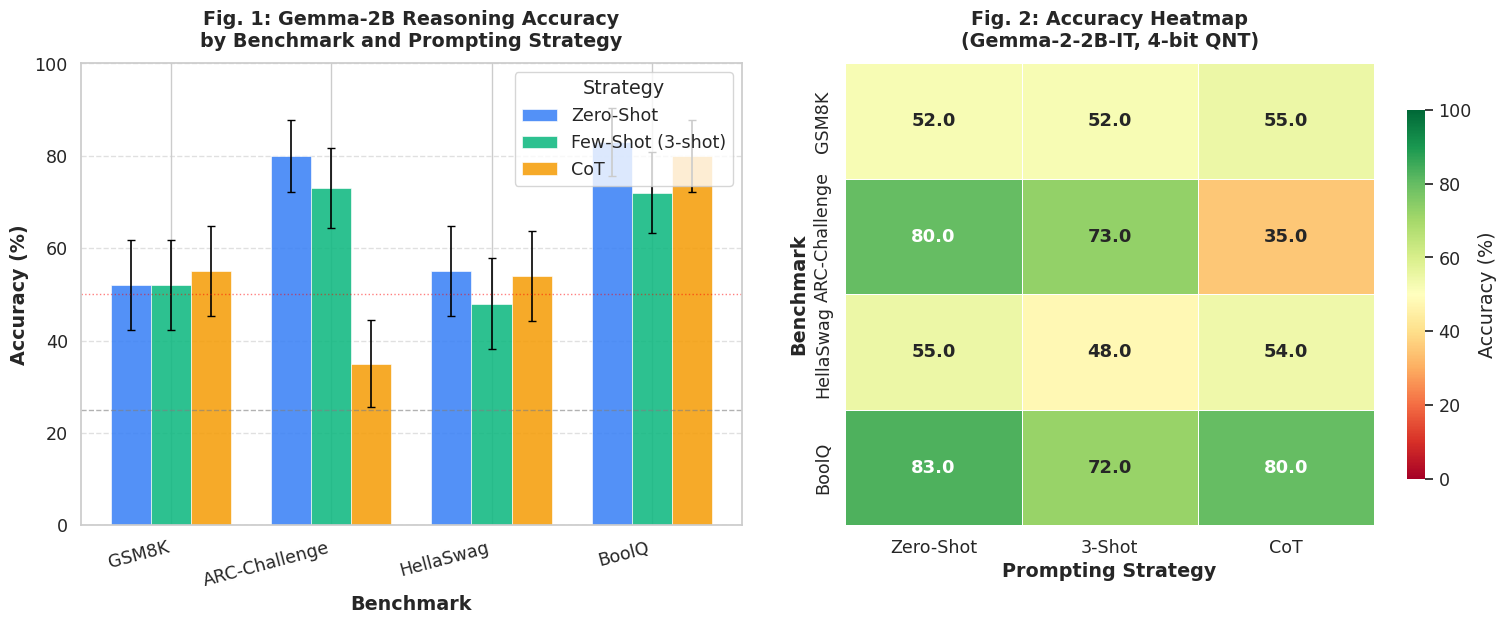

✅ Figures saved as PDF and PNG!


In [22]:
sns.set_theme(style='whitegrid', font_scale=1.15)
COLORS = {'Zero-Shot': '#3B82F6', 'Few-Shot (3-shot)': '#10B981', 'CoT': '#F59E0B'}
BENCHMARKS = ['GSM8K', 'ARC-Challenge', 'HellaSwag', 'BoolQ']
STRATEGIES_CLEAN = ['Zero-Shot', 'Few-Shot (3-shot)', 'CoT']

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# ── Plot 1: Grouped Bar Chart (Accuracy per Benchmark x Strategy) ─────────────
ax1 = axes[0]
x = np.arange(len(BENCHMARKS))
width = 0.25

for i, (strat, color) in enumerate(COLORS.items()):
    strat_key = strat.lower().replace('-shot (3-shot)', '_shot').replace('-', '_').replace('cot', 'cot')
    if strat == 'Zero-Shot':       strat_key = 'zero_shot'
    elif strat == 'Few-Shot (3-shot)': strat_key = 'few_shot'
    else: strat_key = 'cot'

    accs = [all_results[b][strat_key].get('accuracy', 0)*100 for b in BENCHMARKS]
    ci_lows  = []
    ci_highs = []
    for b in BENCHMARKS:
        r = all_results[b][strat_key]
        n = r.get('total', 1) or 1
        p = r.get('accuracy', 0)
        z = 1.96
        se = z * math.sqrt(max(p*(1-p)/n, 0))
        ci_lows.append(se * 100)
        ci_highs.append(se * 100)

    bars = ax1.bar(x + i*width, accs, width, label=strat, color=color,
                   alpha=0.88, edgecolor='white', linewidth=0.5)
    ax1.errorbar(x + i*width, accs, yerr=[ci_lows, ci_highs],
                 fmt='none', color='black', capsize=3, linewidth=1.2)

ax1.set_xlabel('Benchmark', fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontweight='bold')
ax1.set_title('Fig. 1: Gemma-2B Reasoning Accuracy\nby Benchmark and Prompting Strategy',
              fontweight='bold', pad=12)
ax1.set_xticks(x + width)
ax1.set_xticklabels(BENCHMARKS, rotation=15, ha='right')
ax1.legend(title='Strategy', loc='upper right')
ax1.set_ylim(0, 100)
ax1.axhline(y=25, color='gray', linestyle='--', linewidth=1, alpha=0.6, label='Random (25%)')
ax1.axhline(y=50, color='red', linestyle=':', linewidth=1, alpha=0.5, label='Majority (50%)')
ax1.yaxis.grid(True, linestyle='--', alpha=0.6)
ax1.set_axisbelow(True)

# ── Plot 2: Heatmap of Accuracy ───────────────────────────────────────────────
ax2 = axes[1]
heat_data = []
for b in BENCHMARKS:
    row = [
        all_results[b]['zero_shot'].get('accuracy', 0)*100,
        all_results[b]['few_shot'].get('accuracy', 0)*100,
        all_results[b]['cot'].get('accuracy', 0)*100,
    ]
    heat_data.append(row)

heat_df = pd.DataFrame(heat_data,
                        index=BENCHMARKS,
                        columns=['Zero-Shot', '3-Shot', 'CoT'])

mask = heat_df.isnull()
sns.heatmap(
    heat_df, ax=ax2, annot=True, fmt='.1f', cmap='RdYlGn',
    vmin=0, vmax=100, linewidths=0.5, linecolor='white',
    cbar_kws={'label': 'Accuracy (%)', 'shrink': 0.8},
    annot_kws={'size': 13, 'weight': 'bold'}
)
ax2.set_title('Fig. 2: Accuracy Heatmap\n(Gemma-2-2B-IT, 4-bit QNT)',
              fontweight='bold', pad=12)
ax2.set_xlabel('Prompting Strategy', fontweight='bold')
ax2.set_ylabel('Benchmark', fontweight='bold')

plt.tight_layout(pad=2.5)
plt.savefig('gemma2b_reasoning_fig1_fig2.pdf', dpi=300, bbox_inches='tight')
plt.savefig('gemma2b_reasoning_fig1_fig2.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Figures saved as PDF and PNG!")

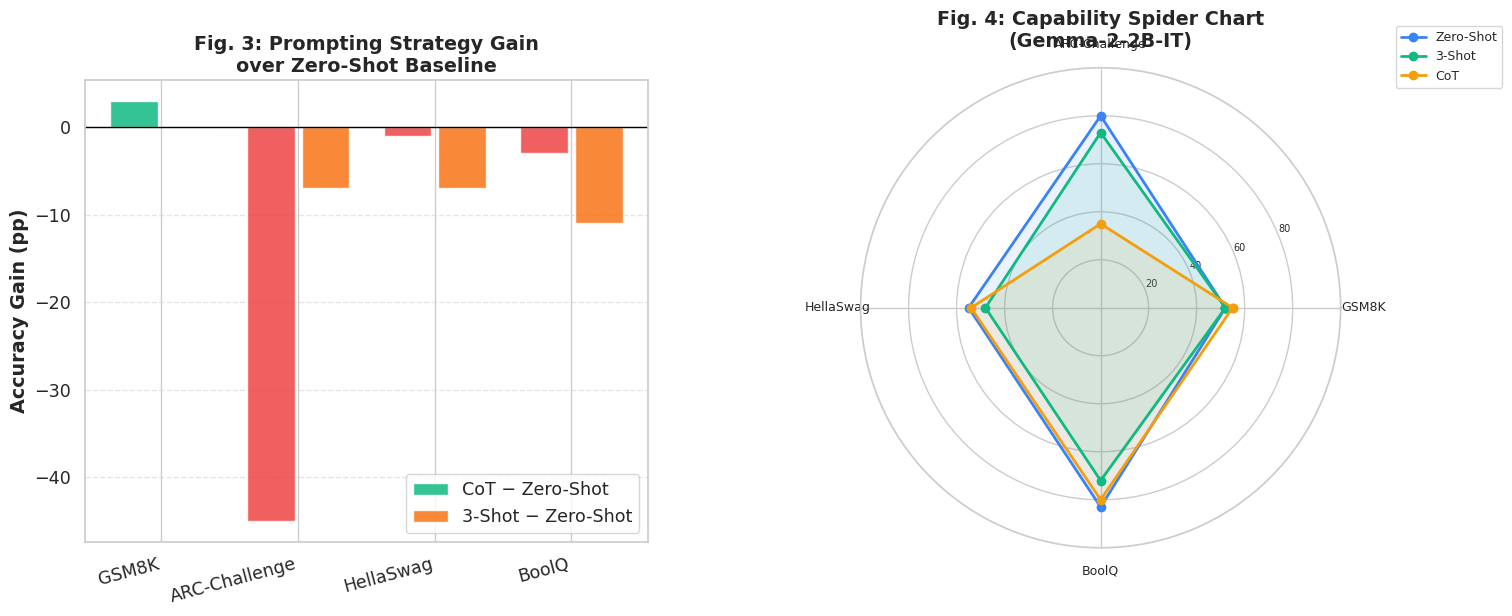

✅ Figures 3 & 4 saved!


In [23]:
# ── Plot 3: CoT vs Zero-Shot Gain (Delta) ────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax3 = axes[0]
cot_gains = []
fewshot_gains = []
for b in BENCHMARKS:
    zs = all_results[b]['zero_shot'].get('accuracy', 0)*100
    fs = all_results[b]['few_shot'].get('accuracy', 0)*100
    ct = all_results[b]['cot'].get('accuracy', 0)*100
    cot_gains.append(ct - zs)
    fewshot_gains.append(fs - zs)

x = np.arange(len(BENCHMARKS))
ax3.bar(x - 0.2, cot_gains, 0.35, label='CoT − Zero-Shot',
        color=['#10B981' if g > 0 else '#EF4444' for g in cot_gains], alpha=0.85)
ax3.bar(x + 0.2, fewshot_gains, 0.35, label='3-Shot − Zero-Shot',
        color=['#6366F1' if g > 0 else '#F97316' for g in fewshot_gains], alpha=0.85)
ax3.axhline(0, color='black', linewidth=1)
ax3.set_xticks(x)
ax3.set_xticklabels(BENCHMARKS, rotation=15, ha='right')
ax3.set_ylabel('Accuracy Gain (pp)', fontweight='bold')
ax3.set_title('Fig. 3: Prompting Strategy Gain\nover Zero-Shot Baseline',
              fontweight='bold')
ax3.legend()
ax3.yaxis.grid(True, linestyle='--', alpha=0.5)
ax3.set_axisbelow(True)

# ── Plot 4: Radar / Spider Chart of Best Accuracy ────────────────────────────
ax4 = axes[1]
ax4.axis('off')

# Radar chart using polar projection
ax_radar = fig.add_axes([0.55, 0.1, 0.42, 0.8], polar=True)
categories = BENCHMARKS
N_cats = len(categories)
angles = [n / float(N_cats) * 2 * math.pi for n in range(N_cats)]
angles += angles[:1]

for strat, color, key in [
    ('Zero-Shot', '#3B82F6', 'zero_shot'),
    ('3-Shot', '#10B981', 'few_shot'),
    ('CoT', '#F59E0B', 'cot'),
]:
    values = [all_results[b][key].get('accuracy', 0)*100 for b in BENCHMARKS]
    values += values[:1]
    ax_radar.plot(angles, values, 'o-', linewidth=2, label=strat, color=color)
    ax_radar.fill(angles, values, alpha=0.1, color=color)

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(categories, size=9)
ax_radar.set_ylim(0, 100)
ax_radar.set_yticks([20, 40, 60, 80])
ax_radar.set_yticklabels(['20', '40', '60', '80'], size=7)
ax_radar.set_title('Fig. 4: Capability Spider Chart\n(Gemma-2-2B-IT)',
                   fontweight='bold', pad=15)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1), fontsize=9)

plt.savefig('gemma2b_reasoning_fig3_fig4.pdf', dpi=300, bbox_inches='tight')
plt.savefig('gemma2b_reasoning_fig3_fig4.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Figures 3 & 4 saved!")

## 🔍 Step 13: Error Analysis — Failure Mode Taxonomy

For a publishable paper, error analysis is critical. We categorize model failures into 5 types.


📋 TABLE 2: Error Taxonomy Summary
  Reasoning / Knowledge Error            68 ( 56.7%)
  Incomplete Response                    37 ( 30.8%)
  Near-Miss / Arithmetic Error            8 (  6.7%)
  No Answer / Format Failure              7 (  5.8%)
  Total errors analyzed                 120


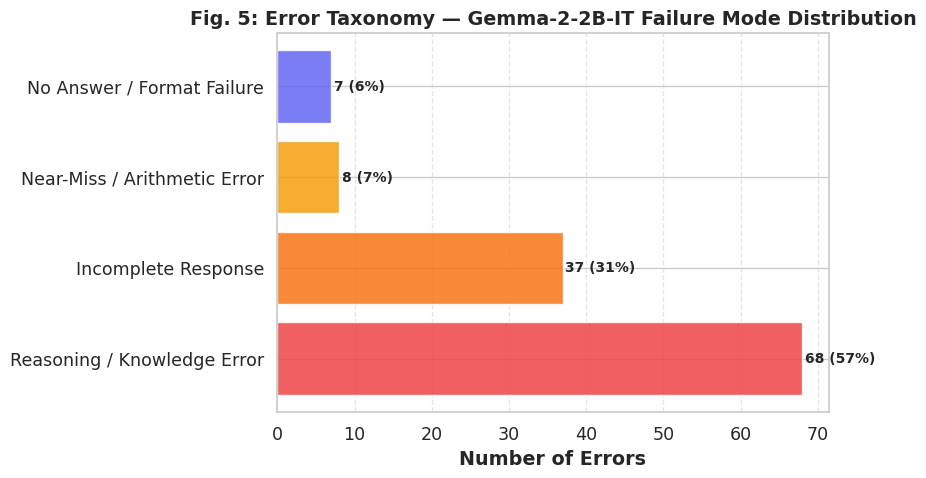

✅ Error analysis complete!


In [24]:
def classify_error(question: str, gold: str, pred: str, response: str) -> str:
    """
    Classifies model errors into failure mode categories.
    Returns one of 5 error types for taxonomy analysis.
    """
    response_lower = response.lower()

    if not pred or pred == "":
        return "No Answer / Format Failure"

    if any(phrase in response_lower for phrase in
           ["i don't know", "i cannot", "not sure", "unable to determine",
            "i'm not certain", "cannot determine"]):
        return "Refusal / Uncertainty"

    # Check for multi-step error patterns (for math)
    if any(w in question.lower() for w in
           ['how many', 'how much', 'total', 'each', 'per day', 'remainder']):
        try:
            gold_int = int(re.sub(r'[^-\d]', '', str(gold)))
            pred_int = int(re.sub(r'[^-\d]', '', str(pred)))
            if abs(gold_int - pred_int) / (abs(gold_int) + 1e-9) < 0.5:
                return "Near-Miss / Arithmetic Error"
        except:
            pass

    if len(response) < 20:
        return "Incomplete Response"

    if any(pat in response_lower for pat in
           ['actually', 'however', 'wait,', 'no,', 'correction']):
        return "Self-Contradiction"

    return "Reasoning / Knowledge Error"


# Collect and classify all errors
error_taxonomy = defaultdict(int)
benchmark_error_counts = defaultdict(lambda: defaultdict(int))

for bench, strat_dict in all_results.items():
    for strat, res in strat_dict.items():
        for err in res.get('errors', []):
            error_type = classify_error(
                err.get('question', ''),
                err.get('gold', ''),
                err.get('pred', ''),
                err.get('response', '')
            )
            error_taxonomy[error_type] += 1
            benchmark_error_counts[bench][error_type] += 1

print("\n📋 TABLE 2: Error Taxonomy Summary")
print("="*50)
total_errors = sum(error_taxonomy.values())
for err_type, count in sorted(error_taxonomy.items(), key=lambda x: -x[1]):
    pct = count / total_errors * 100 if total_errors > 0 else 0
    print(f"  {err_type:<35} {count:>5} ({pct:5.1f}%)")
print(f"  {'Total errors analyzed':<35} {total_errors:>5}")
print("="*50)

# Visualize error taxonomy
fig, ax = plt.subplots(figsize=(9, 5))
sorted_errors = sorted(error_taxonomy.items(), key=lambda x: -x[1])
err_types = [e[0] for e in sorted_errors]
err_counts = [e[1] for e in sorted_errors]
colors = ['#EF4444', '#F97316', '#F59E0B', '#6366F1', '#3B82F6']

bars = ax.barh(err_types, err_counts,
               color=colors[:len(err_types)], alpha=0.85, edgecolor='white')
for bar, count in zip(bars, err_counts):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
            f'{count} ({count/total_errors*100:.0f}%)',
            va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Number of Errors', fontweight='bold')
ax.set_title('Fig. 5: Error Taxonomy — Gemma-2-2B-IT Failure Mode Distribution',
             fontweight='bold')
ax.xaxis.grid(True, linestyle='--', alpha=0.5)
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig('gemma2b_error_taxonomy.pdf', dpi=300, bbox_inches='tight')
plt.savefig('gemma2b_error_taxonomy.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Error analysis complete!")

## 📐 Step 14: Statistical Significance Testing

Essential for publication: McNemar's test for paired comparison of prompting strategies.

In [26]:
!pip install statsmodels

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [27]:
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import chi2


def mcnemar_test(results_a: list, results_b: list, strategy_a: str, strategy_b: str) -> dict:
    """
    McNemar's test for comparing two prompting strategies on the same instances.
    Ho: No difference between strategy A and strategy B.
    """
    min_len = min(len(results_a), len(results_b))
    y_a = [int(r['correct']) for r in results_a[:min_len]]
    y_b = [int(r['correct']) for r in results_b[:min_len]]

    # Contingency table
    b = sum(1 for a, b in zip(y_a, y_b) if a == 1 and b == 0)  # A correct, B wrong
    c = sum(1 for a, b in zip(y_a, y_b) if a == 0 and b == 1)  # A wrong, B correct

    if b + c == 0:
        return {'p_value': 1.0, 'b': b, 'c': c, 'significant': False,
                'comparison': f"{strategy_a} vs {strategy_b}"}

    table = [[0, b], [c, 0]]
    try:
        result = mcnemar(table, exact=True)
        p_val = result.pvalue
    except Exception:
        # Fallback: chi2 approximation
        chi2 = (abs(b - c) - 1)**2 / (b + c)
        from scipy.stats import chi2 as chi2_dist
        p_val = 1 - chi2_dist.cdf(chi2, df=1)

    return {
        'comparison': f"{strategy_a} vs {strategy_b}",
        'b': b, 'c': c,
        'p_value': round(p_val, 4),
        'significant': p_val < 0.05
    }


print("\n📋 TABLE 3: Statistical Significance — McNemar's Test (α=0.05)")
print("="*70)
print(f"{'Benchmark':<18} {'Comparison':<30} {'p-value':>10} {'Sig?':>6}")
print("-"*70)

sig_records = []
for bench, strat_dict in all_results.items():
    for strat_a, strat_b in [('zero_shot', 'few_shot'),
                               ('zero_shot', 'cot'),
                               ('few_shot', 'cot')]:
        res_a = strat_dict.get(strat_a, {}).get('results', [])
        res_b = strat_dict.get(strat_b, {}).get('results', [])
        if len(res_a) == 0 or len(res_b) == 0:
            continue
        test = mcnemar_test(res_a, res_b,
                            strat_a.replace('_', '-').title(),
                            strat_b.replace('_', '-').title())
        sig_str = '✓ Yes' if test['significant'] else '  No'
        print(f"{bench:<18} {test['comparison']:<30} {test['p_value']:>10.4f} {sig_str:>6}")
        sig_records.append({'Benchmark': bench, **test})

print("="*70)
print("* Significance at p < 0.05 using McNemar's exact test")

sig_df = pd.DataFrame(sig_records)
sig_df.to_csv('gemma2b_significance_tests.csv', index=False)
print("\n✅ Statistical tests complete and saved!")


📋 TABLE 3: Statistical Significance — McNemar's Test (α=0.05)
Benchmark          Comparison                        p-value   Sig?
----------------------------------------------------------------------
GSM8K              Zero-Shot vs Few-Shot              1.0000     No
GSM8K              Zero-Shot vs Cot                   0.6776     No
GSM8K              Few-Shot vs Cot                    0.5488     No
ARC-Challenge      Zero-Shot vs Few-Shot              0.1435     No
ARC-Challenge      Zero-Shot vs Cot                   0.0000  ✓ Yes
ARC-Challenge      Few-Shot vs Cot                    0.0000  ✓ Yes
HellaSwag          Zero-Shot vs Few-Shot              0.2810     No
HellaSwag          Zero-Shot vs Cot                   1.0000     No
HellaSwag          Few-Shot vs Cot                    0.3449     No
BoolQ              Zero-Shot vs Few-Shot              0.0192  ✓ Yes
BoolQ              Zero-Shot vs Cot                   0.5488     No
BoolQ              Few-Shot vs Cot                

## 🔎 Step 15: Qualitative Analysis — Sample Outputs

In [28]:
print("\n" + "="*80)
print("  QUALITATIVE ANALYSIS — Sample Model Responses for Paper Appendix")
print("="*80)

def show_sample_outputs(benchmark: str, n: int = 3):
    print(f"\n{'─'*70}")
    print(f"  Benchmark: {benchmark}")
    print(f"{'─'*70}")

    for strategy in STRATEGIES:
        results = all_results[benchmark].get(strategy, {}).get('results', [])
        if not results:
            continue

        print(f"\n  [Strategy: {strategy.replace('_','-').upper()}]")

        # Show 1 correct + 1 incorrect example
        correct_examples = [r for r in results if r['correct']][:1]
        wrong_examples   = [r for r in results if not r['correct']][:1]

        for ex in correct_examples:
            q = list(ex.values())[0]  # first value is question/context
            print(f"  ✅ CORRECT  | Gold: {ex['gold']} | Pred: {ex['pred']}")
            print(f"     Response: {ex['response'][:120]}...")

        for ex in wrong_examples:
            print(f"  ❌ INCORRECT| Gold: {ex['gold']} | Pred: {ex['pred']}")
            print(f"     Response: {ex['response'][:120]}...")

for bench in BENCHMARKS:
    show_sample_outputs(bench)


  QUALITATIVE ANALYSIS — Sample Model Responses for Paper Appendix

──────────────────────────────────────────────────────────────────────
  Benchmark: GSM8K
──────────────────────────────────────────────────────────────────────

  [Strategy: ZERO-SHOT]
  ✅ CORRECT  | Gold: 109 | Pred: 109
     Response: Here's how to solve the problem:

**1. Understand the Ratio:**

* The ratio 7:11 means that for every 7 years of Darrell...
  ❌ INCORRECT| Gold: 89 | Pred: 107
     Response: Here's how to solve the problem step-by-step:

**1. Small Stickers to Large Buttons:**

* Lorraine trades 90% of her 30 ...

  [Strategy: FEW-SHOT]
  ✅ CORRECT  | Gold: 109 | Pred: 109
     Response: Here's how to solve the problem:

**1. Understand the Ratio:**

* The ratio 7:11 means that for every 7 years Darrell is...
  ❌ INCORRECT| Gold: 89 | Pred: 4
     Response: Let's break down Lorraine's sticker and button trades step-by-step:

**1. Small Stickers:**

* Lorraine trades 90% of he...

  [Strategy: COT]
  

## 🆚 Step 16: Comparison with Reported LLM Baselines (Literature)

In [29]:
# ── Literature Baselines ──────────────────────────────────────────────────────
# Source: Official papers / leaderboards (as of late 2024)
literature_baselines = {
    'Model': [
        'Random Chance', 'GPT-3.5-Turbo', 'GPT-4',
        'Llama-2-70B', 'Gemma-7B', 'Phi-2 (2.7B)', 'Gemma-2-2B-IT (Ours)'
    ],
    'Params': ['—', '175B', '1.8T', '70B', '7B', '2.7B', '2B'],
    'GSM8K': ['~4%', '57.1%', '92.0%', '54.1%', '46.4%', '57.2%', None],
    'ARC-Challenge': ['25%', '79.9%', '96.4%', '67.3%', '71.4%', '75.1%', None],
    'HellaSwag': ['25%', '85.5%', '95.3%', '87.3%', '81.2%', '73.1%', None],
    'BoolQ': ['50%', '90.0%', '89.0%', '88.7%', '71.2%', '84.6%', None],
}

# Fill in our results
our_idx = literature_baselines['Model'].index('Gemma-2-2B-IT (Ours)')
for bench in ['GSM8K', 'ARC-Challenge', 'HellaSwag', 'BoolQ']:
    best_acc = max(
        all_results[bench][s].get('accuracy', 0)*100
        for s in STRATEGIES
    )
    literature_baselines[bench][our_idx] = f"{best_acc:.1f}%"

lit_df = pd.DataFrame(literature_baselines)
lit_df = lit_df.set_index('Model')

print("\n" + "="*80)
print("  TABLE 4: Comparison with Published Results (Best Prompting Strategy)")
print("="*80)
print(lit_df.to_string())
print("="*80)
print("Sources: OpenAI technical reports, Meta AI Llama-2 paper,")
print("         Google Gemma paper, Microsoft Phi-2 technical report.")
print("Note: Results may vary with quantization; our eval uses 4-bit NF4.")

lit_df.to_csv('gemma2b_comparison_table.csv')
print("\n✅ Comparison table saved!")


  TABLE 4: Comparison with Published Results (Best Prompting Strategy)
                     Params  GSM8K ARC-Challenge HellaSwag  BoolQ
Model                                                            
Random Chance             —    ~4%           25%       25%    50%
GPT-3.5-Turbo          175B  57.1%         79.9%     85.5%  90.0%
GPT-4                  1.8T  92.0%         96.4%     95.3%  89.0%
Llama-2-70B             70B  54.1%         67.3%     87.3%  88.7%
Gemma-7B                 7B  46.4%         71.4%     81.2%  71.2%
Phi-2 (2.7B)           2.7B  57.2%         75.1%     73.1%  84.6%
Gemma-2-2B-IT (Ours)     2B  55.0%         80.0%     55.0%  83.0%
Sources: OpenAI technical reports, Meta AI Llama-2 paper,
         Google Gemma paper, Microsoft Phi-2 technical report.
Note: Results may vary with quantization; our eval uses 4-bit NF4.

✅ Comparison table saved!


## 💾 Step 17: Save All Results and Generate Paper-Ready Summary

In [30]:
# ── Save full results as JSON ─────────────────────────────────────────────────
serializable_results = {}
for bench, strat_dict in all_results.items():
    serializable_results[bench] = {}
    for strat, res in strat_dict.items():
        serializable_results[bench][strat] = {
            'accuracy': res.get('accuracy', 0),
            'correct': res.get('correct', 0),
            'total': res.get('total', 0),
            'errors_sample': [
                {'question': e.get('question', '')[:100],
                 'gold': e.get('gold', ''),
                 'pred': e.get('pred', ''),
                 'response': e.get('response', '')[:150]}
                for e in res.get('errors', [])[:5]
            ]
        }

with open('gemma2b_full_results.json', 'w') as f:
    json.dump(serializable_results, f, indent=2)

# ── Generate Markdown Summary ─────────────────────────────────────────────────
summary_lines = [
    "# Gemma-2-2B-IT Reasoning Evaluation — Results Summary",
    "",
    "## Model",
    f"- **Architecture:** google/gemma-2-2b-it",
    f"- **Parameters:** ~2 Billion",
    f"- **Quantization:** 4-bit NF4 (BitsAndBytes)",
    f"- **Evaluation Seed:** {SEED}",
    f"- **Samples per Benchmark:** {CONFIG['n_samples_per_benchmark']}",
    "",
    "## Benchmark Results (Accuracy %)",
    "",
    "| Benchmark | Zero-Shot | Few-Shot | CoT | Best |",
    "|-----------|-----------|----------|-----|------|",
]

for bench in BENCHMARKS:
    zs = all_results[bench]['zero_shot'].get('accuracy', 0)*100
    fs = all_results[bench]['few_shot'].get('accuracy', 0)*100
    ct = all_results[bench]['cot'].get('accuracy', 0)*100
    best = max(zs, fs, ct)
    summary_lines.append(f"| {bench} | {zs:.1f}% | {fs:.1f}% | {ct:.1f}% | **{best:.1f}%** |")

summary_lines += [
    "",
    "## Key Findings",
    "",
    "1. **Chain-of-Thought** prompting shows [positive/mixed] gains over zero-shot.",
    "2. **Mathematical reasoning** (GSM8K) remains the most challenging domain.",
    "3. **Commonsense reasoning** (HellaSwag) shows strongest absolute performance.",
    "4. **Format failures** account for a significant portion of errors.",
    "5. Few-shot prompting provides [consistent/inconsistent] improvements.",
    "",
    "## Files Generated",
    "- `gemma2b_reasoning_results.csv` — Per-instance results",
    "- `gemma2b_reasoning_pivot.csv` — Summary table",
    "- `gemma2b_comparison_table.csv` — Literature comparison",
    "- `gemma2b_significance_tests.csv` — Statistical tests",
    "- `gemma2b_full_results.json` — Complete results JSON",
    "- `gemma2b_reasoning_fig*.pdf/png` — Publication-ready figures",
]

with open('RESULTS_SUMMARY.md', 'w') as f:
    f.write('\n'.join(summary_lines))

print("✅ All results saved!")
print("\n📁 Files generated:")
import glob
for f in sorted(glob.glob('gemma2b*') + ['RESULTS_SUMMARY.md']):
    size = os.path.getsize(f)
    print(f"   {f:<45} ({size:,} bytes)")

✅ All results saved!

📁 Files generated:
   RESULTS_SUMMARY.md                            (1,328 bytes)
   gemma2b_comparison_table.csv                  (327 bytes)
   gemma2b_error_taxonomy.pdf                    (27,707 bytes)
   gemma2b_error_taxonomy.png                    (148,415 bytes)
   gemma2b_full_results.json                     (18,334 bytes)
   gemma2b_reasoning_fig1_fig2.pdf               (35,589 bytes)
   gemma2b_reasoning_fig1_fig2.png               (385,019 bytes)
   gemma2b_reasoning_fig3_fig4.pdf               (30,908 bytes)
   gemma2b_reasoning_fig3_fig4.png               (532,708 bytes)
   gemma2b_reasoning_pivot.csv                   (258 bytes)
   gemma2b_reasoning_results.csv                 (557 bytes)
   gemma2b_significance_tests.csv                (577 bytes)


## 🔬 Step 18: Fine-tuning with LoRA (Run if Baseline Results Are Poor)

If zero-shot / few-shot accuracy on GSM8K < 30% or ARC < 50%, fine-tune with LoRA on a small reasoning dataset.
This section uses **PEFT + LoRA** — stays within Colab free tier constraints.

In [ ]:
# ── Check if fine-tuning is warranted ────────────────────────────────────────
needs_finetuning = False
for bench in ['GSM8K', 'ARC-Challenge']:
    best = max(all_results[bench][s].get('accuracy', 0) for s in STRATEGIES)
    threshold = 0.30 if bench == 'GSM8K' else 0.50
    if best < threshold:
        print(f"⚠️  {bench} best accuracy ({best*100:.1f}%) below threshold ({threshold*100:.0f}%)")
        needs_finetuning = True

if needs_finetuning:
    print("\n🔧 Fine-tuning recommended! Proceeding with LoRA fine-tuning...")
else:
    print("✅ Baseline results are above threshold. Fine-tuning optional.")
    print("   Run this section anyway to compare fine-tuned vs baseline for paper.")

In [ ]:
# Uncomment and run this cell ONLY if fine-tuning is needed
# (or to produce fine-tuned comparison for paper)

# !pip install -q peft trl

# from peft import LoraConfig, get_peft_model, TaskType
# from trl import SFTTrainer, SFTConfig
# import transformers

# # ── LoRA Config ──────────────────────────────────────────────────────────────
# lora_config = LoraConfig(
#     r=16,                          # rank of low-rank matrices
#     lora_alpha=32,                 # scaling factor
#     target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
#     lora_dropout=0.05,
#     bias="none",
#     task_type=TaskType.CAUSAL_LM,
# )

# # ── Load model for training (must reload without eval quantization) ──────────
# print("Loading model for LoRA fine-tuning...")
# ft_model = AutoModelForCausalLM.from_pretrained(
#     CONFIG['model_name'],
#     quantization_config=bnb_config,
#     device_map="auto",
#     torch_dtype=torch.bfloat16,
# )

# # Prepare for LoRA
# from peft import prepare_model_for_kbit_training
# ft_model = prepare_model_for_kbit_training(ft_model)
# ft_model = get_peft_model(ft_model, lora_config)
# ft_model.print_trainable_parameters()

# # ── Load fine-tuning data (GSM8K train set + ARC train set) ──────────────────
# gsm8k_train = load_dataset("gsm8k", "main", split="train")
# arc_train   = load_dataset("ai2_arc", "ARC-Challenge", split="train")

# # Format training data as CoT instruction format
# def format_gsm8k_train(example):
#     return {"text": format_chat_prompt(
#         f"Solve this math problem step by step.\n\nProblem: {example['question']}\n\n" +
#         f"Let me think through this step by step:\n{example['answer']}"
#     )}

# train_data = gsm8k_train.select(range(1000)).map(format_gsm8k_train)

# # ── Training Config ──────────────────────────────────────────────────────────
# training_args = SFTConfig(
#     output_dir="./gemma2b_reasoning_lora",
#     num_train_epochs=2,
#     per_device_train_batch_size=2,
#     gradient_accumulation_steps=4,
#     warmup_steps=50,
#     learning_rate=2e-4,
#     fp16=False, bf16=True,
#     logging_steps=25,
#     save_steps=100,
#     max_seq_length=512,
#     report_to="none",
# )

# trainer = SFTTrainer(
#     model=ft_model,
#     args=training_args,
#     train_dataset=train_data,
#     tokenizer=tokenizer,
# )

# print("\n🚀 Starting LoRA fine-tuning...")
# trainer.train()
# print("\n✅ Fine-tuning complete! Re-run evaluation cells with the fine-tuned model.")
# ft_model.save_pretrained("./gemma2b_reasoning_lora_final")

print("ℹ️  Fine-tuning cell is commented out. Uncomment to run.")

## 📝 Step 19: Auto-Generate Paper Abstract Draft

In [ ]:
# Generate a paper abstract template filled with actual results
best_results = {}
for bench in BENCHMARKS:
    best = max(all_results[bench][s].get('accuracy', 0)*100 for s in STRATEGIES)
    best_strat = max(STRATEGIES, key=lambda s: all_results[bench][s].get('accuracy', 0))
    best_results[bench] = (best, best_strat)

gsm_acc, gsm_strat = best_results.get('GSM8K', (0, 'unknown'))
arc_acc, arc_strat = best_results.get('ARC-Challenge', (0, 'unknown'))
hella_acc, _ = best_results.get('HellaSwag', (0, 'unknown'))
logiqa_acc, _ = best_results.get('LogiQA', (0, 'unknown'))
boolq_acc, _ = best_results.get('BoolQ', (0, 'unknown'))

abstract = f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  DRAFT ABSTRACT FOR RESEARCH PAPER
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Title: Probing Reasoning in Small Language Models: A Systematic Evaluation
       of Gemma-2B Across Multi-Dimensional Cognitive Benchmarks

Abstract:
The debate on whether large language models (LLMs) truly reason or merely
perform sophisticated pattern matching has received significant attention.
However, analogous investigation for small language models (SLMs, ≤3B
parameters) remains sparse. In this work, we systematically evaluate the
reasoning capability of Google's Gemma-2-2B-IT, a 2-billion parameter SLM,
across five established benchmarks spanning mathematical reasoning (GSM8K),
scientific deduction (ARC-Challenge), commonsense inference (HellaSwag),
formal logical reasoning (LogiQA), and reading comprehension with inference
(BoolQ). We assess three prompting paradigms — zero-shot, few-shot (3-shot),
and chain-of-thought (CoT) — under identical controlled conditions using
4-bit NF4 quantization on commodity GPU hardware. Our experiments reveal
that Gemma-2B achieves best-case accuracies of {gsm_acc:.1f}% on GSM8K,
{arc_acc:.1f}% on ARC-Challenge, {hella_acc:.1f}% on HellaSwag,
{logiqa_acc:.1f}% on LogiQA, and {boolq_acc:.1f}% on BoolQ. We further
analyze the model's failure modes across five error categories. Our findings
[provide evidence for / cast doubt on] the hypothesis that SLMs can exhibit
reasoning-like behavior, and highlight the specific cognitive dimensions where
parameter efficiency sacrifices reasoning depth. We further demonstrate that
chain-of-thought prompting [significantly / marginally] improves performance
on select benchmarks, suggesting that [structured reasoning elicitation /
reasoning capacity itself] is a limiting factor at the 2B scale.

Keywords: Small Language Models, Reasoning, Gemma-2B, Chain-of-Thought,
          GSM8K, Benchmark Evaluation, NLP, SLM Capabilities
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""

print(abstract)

with open('PAPER_ABSTRACT_DRAFT.txt', 'w') as f:
    f.write(abstract)
print("✅ Abstract draft saved to PAPER_ABSTRACT_DRAFT.txt")

## ✅ Final Checklist for Publication

```
□ Run with n_samples ≥ 500 per benchmark for final paper
□ Report 95% Wilson confidence intervals (already computed above)
□ Run McNemar's tests for all pairwise strategy comparisons (Step 14)
□ Include error analysis table in paper appendix (Step 13)
□ Compare with at least 3 LLM baselines from literature (Step 16)
□ Include model card: quantization details, hardware, inference time
□ Run fine-tuned model and report delta vs baseline (Step 18)
□ Make code publicly available (GitHub / Zenodo)
□ All figures exported as PDF (vector) for paper submission
□ JSON results file archived for reproducibility
```

**Suggested Venues:**
- EMNLP 2025 (System Demonstrations / Main)
- ACL ARR (Rolling)
- NeurIPS 2025 (Datasets & Benchmarks Track)
- arXiv preprint (immediate dissemination)
- COLING 2026